In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moazeldsokyx/plantvillage")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantvillage


In [89]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121, ResNet50
from keras.optimizers import Adam
sns.set()

In [3]:
images, labels = [], []

In [4]:
for i in os.listdir('/kaggle/input/plantvillage/dataset/train'):
    for j in os.listdir(os.path.join('/kaggle/input/plantvillage/dataset/train', i)):
        image = os.path.join('/kaggle/input/plantvillage/dataset/train', i, j)
        img = cv2.imread(image)
        if img is None:
            print('Wrong path')
        else:
            resized_img = cv2.resize(img, (80, 80))
            images.append(resized_img)
            labels.append(i)

In [5]:
images[0]

array([[[161, 154, 161],
        [172, 165, 172],
        [162, 156, 162],
        ...,
        [130, 126, 138],
        [125, 121, 133],
        [135, 131, 143]],

       [[173, 166, 173],
        [173, 166, 173],
        [155, 148, 155],
        ...,
        [125, 121, 133],
        [117, 113, 125],
        [116, 112, 125]],

       [[163, 156, 163],
        [172, 165, 172],
        [161, 154, 161],
        ...,
        [119, 115, 127],
        [112, 108, 120],
        [122, 118, 130]],

       ...,

       [[155, 151, 162],
        [163, 159, 170],
        [161, 157, 168],
        ...,
        [128, 126, 138],
        [141, 139, 151],
        [133, 131, 143]],

       [[161, 157, 168],
        [156, 152, 163],
        [158, 154, 165],
        ...,
        [126, 125, 136],
        [120, 117, 130],
        [111, 109, 121]],

       [[158, 153, 165],
        [162, 158, 169],
        [145, 141, 152],
        ...,
        [120, 118, 130],
        [121, 119, 131],
        [126, 124, 136]]

In [6]:
labels[0]

'Pepper__bell___Bacterial_spot'

In [7]:
images, labels = shuffle(images, labels)

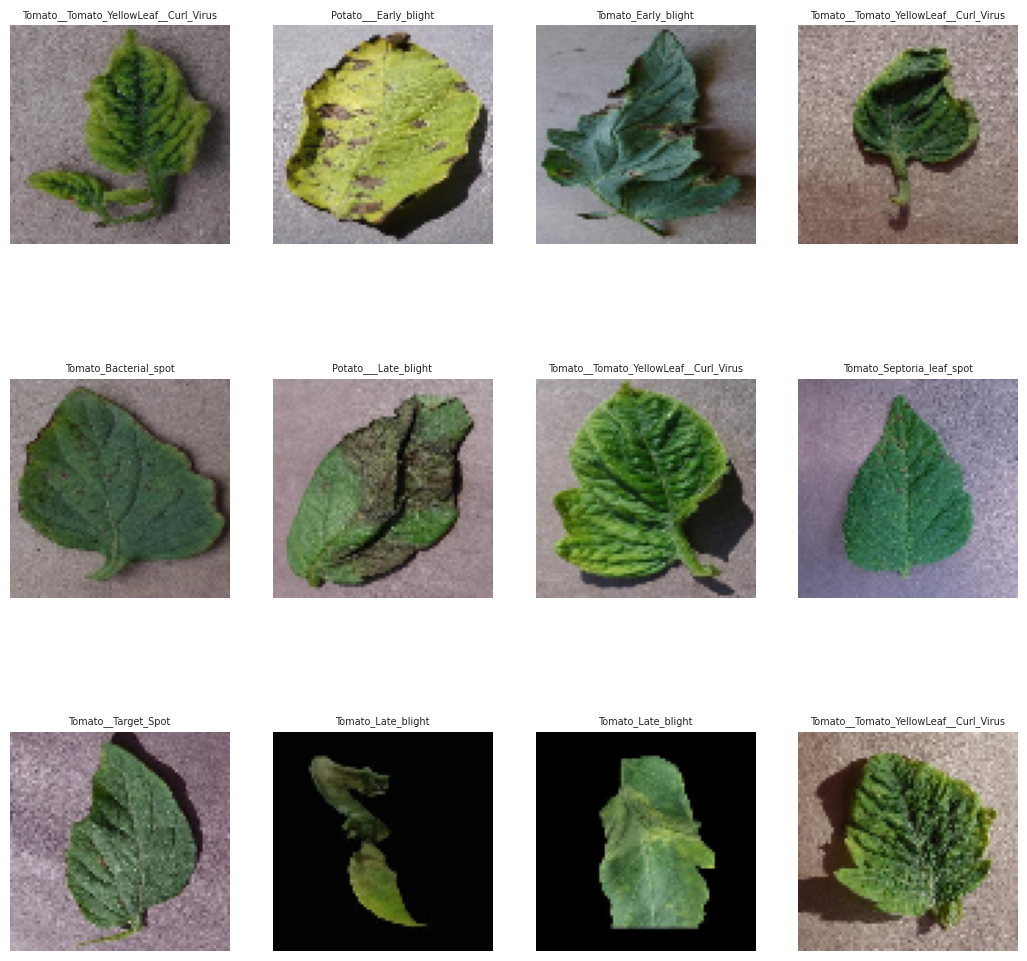

In [8]:
plt.figure(figsize = (13, 13))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    imge = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
    plt.imshow(imge)
    plt.title(labels[i], fontsize = 7)
    plt.axis('off')

In [9]:
df_labels = pd.DataFrame()
df_labels['labels'] = labels
df_labels.head()

,labels
0,Tomato__Tomato_YellowLeaf__Curl_Virus
1,Potato___Early_blight
2,Tomato_Early_blight
3,Tomato__Tomato_YellowLeaf__Curl_Virus
4,Tomato_Bacterial_spot


In [10]:
print('The number of images in the training set is:', len(images))
print('The number of classes in the training set is:', df_labels['labels'].nunique())
print('The shape of images is:', images[0].shape)
print('The classes are:', df_labels['labels'].unique())

The number of images in the training set is: 16504
The number of classes in the training set is: 15
The shape of images is: (80, 80, 3)
The classes are: ['Tomato__Tomato_YellowLeaf__Curl_Virus' 'Potato___Early_blight'
 'Tomato_Early_blight' 'Tomato_Bacterial_spot' 'Potato___Late_blight'
 'Tomato_Septoria_leaf_spot' 'Tomato__Target_Spot' 'Tomato_Late_blight'
 'Pepper__bell___Bacterial_spot' 'Potato___healthy'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Pepper__bell___healthy'
 'Tomato_Leaf_Mold' 'Tomato_healthy' 'Tomato__Tomato_mosaic_virus']


In [11]:
images = np.array(images)

In [12]:
images = images / 255

In [13]:
images[0]

array([[[0.58431373, 0.56862745, 0.61176471],
        [0.54509804, 0.52941176, 0.57254902],
        [0.62352941, 0.60392157, 0.65098039],
        ...,
        [0.45490196, 0.43921569, 0.48235294],
        [0.41960784, 0.40392157, 0.44705882],
        [0.43921569, 0.42352941, 0.46666667]],

       [[0.5254902 , 0.50980392, 0.54901961],
        [0.47058824, 0.45490196, 0.49803922],
        [0.58823529, 0.57254902, 0.61568627],
        ...,
        [0.42352941, 0.40784314, 0.45098039],
        [0.45098039, 0.43529412, 0.47843137],
        [0.40784314, 0.39215686, 0.43529412]],

       [[0.56862745, 0.55294118, 0.59607843],
        [0.52156863, 0.50588235, 0.54901961],
        [0.55686275, 0.54117647, 0.58431373],
        ...,
        [0.45490196, 0.43921569, 0.48235294],
        [0.4627451 , 0.44705882, 0.49019608],
        [0.45490196, 0.43921569, 0.48235294]],

       ...,

       [[0.61176471, 0.59607843, 0.63921569],
        [0.56078431, 0.54509804, 0.58823529],
        [0.58039216, 0

In [14]:
le = LabelEncoder()

In [15]:
y_train = le.fit_transform(labels)

In [16]:
X_train = images

In [17]:
test_images, test_labels = [], []

In [18]:
for i in os.listdir('/kaggle/input/plantvillage/dataset/test'):
    for j in os.listdir(os.path.join('/kaggle/input/plantvillage/dataset/test', i)):
        image = os.path.join('/kaggle/input/plantvillage/dataset/test', i, j)
        img = cv2.imread(image)
        if img is None:
            print('Wrong path')
        else:
            resized_img = cv2.resize(img, (80, 80))
            test_images.append(resized_img)
            test_labels.append(i)

In [20]:
test_images = np.array(test_images)

In [21]:
X_test = test_images / 255

In [22]:
y_test = le.transform(test_labels)

In [23]:
print('The number of images in the test set is:', len(X_test))

The number of images in the test set is: 2064


In [24]:
val_images, val_labels = [], []

In [25]:
for i in os.listdir('/kaggle/input/plantvillage/dataset/validation'):
    for j in os.listdir(os.path.join('/kaggle/input/plantvillage/dataset/validation', i)):
        image = os.path.join('/kaggle/input/plantvillage/dataset/validation', i, j)
        img = cv2.imread(image)
        if img is None:
            print('Wrong path')
        else:
            resized_img = cv2.resize(img, (80, 80))
            val_images.append(resized_img)
            val_labels.append(i)

In [26]:
val_images = np.array(val_images)

In [27]:
X_val = val_images / 255

In [28]:
y_val = le.transform(val_labels)

In [29]:
print('The number of images in the validation set is:', len(X_val))

The number of images in the validation set is: 2070


In [30]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2)

In [31]:
model = Sequential()

In [32]:
model.add(Input(shape = (80, 80, 3)))
model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(15, activation = 'softmax'))

In [33]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [34]:
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_val, y_val), callbacks = [early_stopping])

Epoch 1/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.4602 - loss: 1.6885 - val_accuracy: 0.8019 - val_loss: 0.5817
Epoch 2/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8141 - loss: 0.5630 - val_accuracy: 0.8232 - val_loss: 0.5202
Epoch 3/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8795 - loss: 0.3494 - val_accuracy: 0.8908 - val_loss: 0.3508
Epoch 4/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9279 - loss: 0.2169 - val_accuracy: 0.9135 - val_loss: 0.2734
Epoch 5/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9403 - loss: 0.1665 - val_accuracy: 0.9130 - val_loss: 0.3028
Epoch 6/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9614 - loss: 0.1167 - val_accuracy: 0.9135 - val_loss: 0.3264


In [35]:
model.evaluate(X_test, y_test)

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9245 - loss: 0.2215


[0.25938284397125244, 0.9113371968269348]

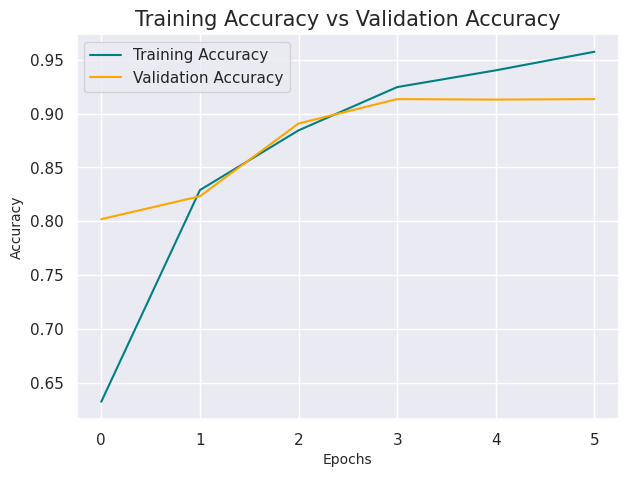

In [36]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', color = 'orange')
plt.title('Training Accuracy vs Validation Accuracy', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.legend()
plt.show()

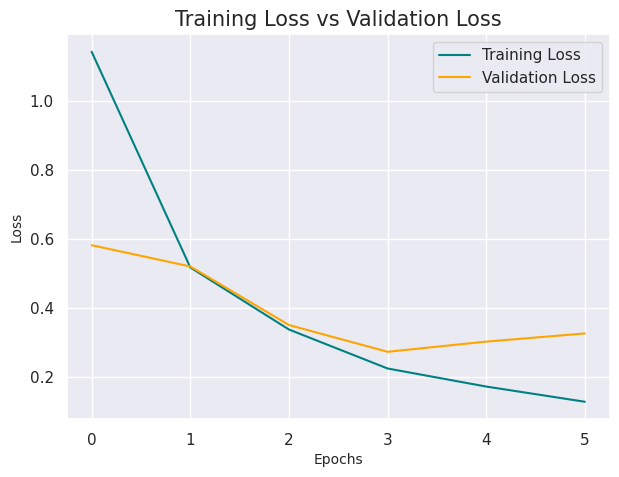

In [37]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training Loss vs Validation Loss', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

In [38]:
y_pred = model.predict(X_test)

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [41]:
y_p = [np.argmax(i) for i in y_pred]

In [42]:
print(classification_report(y_test, y_p))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91       100
           1       0.93      1.00      0.96       148
           2       0.96      0.98      0.97       100
           3       0.77      0.96      0.85       100
           4       0.82      0.93      0.87        15
           5       0.95      0.98      0.97       213
           6       0.92      0.59      0.72       100
           7       0.86      0.77      0.81       191
           8       0.88      0.94      0.91        95
           9       0.84      0.89      0.86       177
          10       0.96      0.90      0.93       168
          11       0.82      0.95      0.88       140
          12       0.98      0.98      0.98       321
          13       0.84      1.00      0.91        37
          14       1.00      0.87      0.93       159

    accuracy                           0.91      2064
   macro avg       0.90      0.91      0.90      2064
weighted avg       0.92   

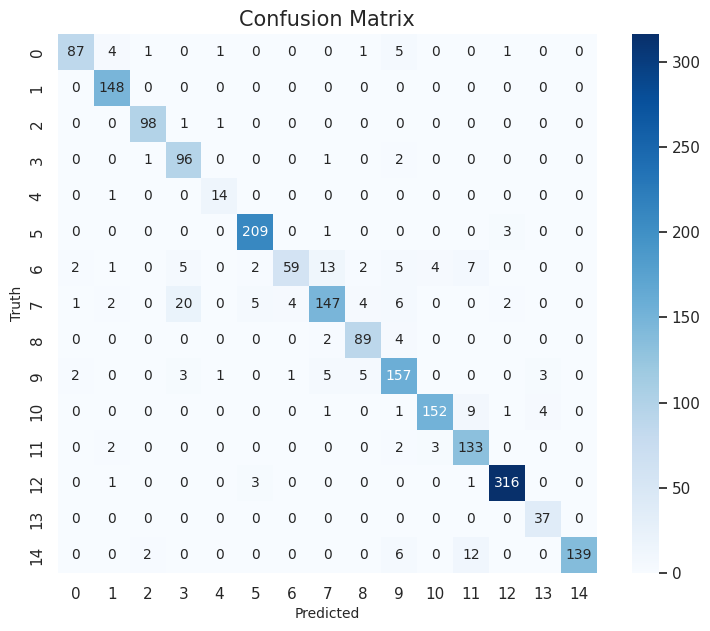

In [44]:
plt.figure(figsize = (9, 7))
sns.heatmap(confusion_matrix(y_test, y_p), annot = True, square = True, cbar = True, annot_kws = {'size': 10}, fmt = 'd',
           cmap = 'Blues')
plt.title('Confusion Matrix', fontsize = 15)
plt.xlabel('Predicted', fontsize = 10)
plt.ylabel('Truth', fontsize = 10)
plt.show()

In [55]:
model2 = Sequential()

In [56]:
model2.add(Input(shape = (80, 80, 3)))
model2.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2, 2)))
model2.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2, 2)))
model2.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2, 2)))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(128, activation = 'relu'))
model2.add(Dropout(0.2))
model2.add(Dense(15, activation = 'softmax'))

In [57]:
model2.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [59]:
early_stopping2 = EarlyStopping(monitor = 'val_loss', patience = 3)

In [60]:
history2 = model2.fit(X_train, y_train, epochs = 100, validation_data = (X_val, y_val), callbacks = [early_stopping2])

Epoch 1/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.3945 - loss: 1.8833 - val_accuracy: 0.7647 - val_loss: 0.7433
Epoch 2/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7719 - loss: 0.7064 - val_accuracy: 0.8570 - val_loss: 0.4614
Epoch 3/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8306 - loss: 0.5115 - val_accuracy: 0.8623 - val_loss: 0.4522
Epoch 4/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8645 - loss: 0.3992 - val_accuracy: 0.8952 - val_loss: 0.3605
Epoch 5/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8940 - loss: 0.3214 - val_accuracy: 0.8928 - val_loss: 0.3675
Epoch 6/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9042 - loss: 0.2804 - val_accuracy: 0.9174 - val_loss: 0.2986
Epoch 7/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9253 - loss: 0.2270 - val_accuracy: 0.8990 - val_loss: 0.3346
Epoch 8/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9276 - loss: 0.2090 - val_ac

In [62]:
model2.evaluate(X_test, y_test)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9171 - loss: 0.2673


[0.262926310300827, 0.913759708404541]

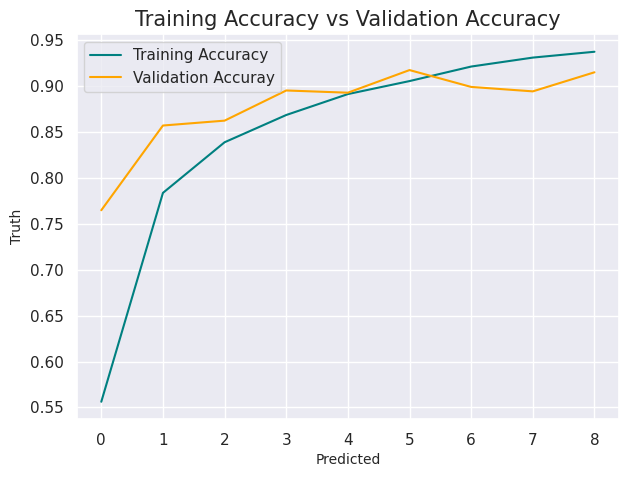

In [63]:
plt.figure(figsize = (7, 5))
plt.plot(history2.history['accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history2.history['val_accuracy'], label = 'Validation Accuray', color = 'orange')
plt.title('Training Accuracy vs Validation Accuracy', fontsize = 15)
plt.xlabel('Predicted', fontsize = 10)
plt.ylabel('Truth', fontsize = 10)
plt.legend()
plt.show()

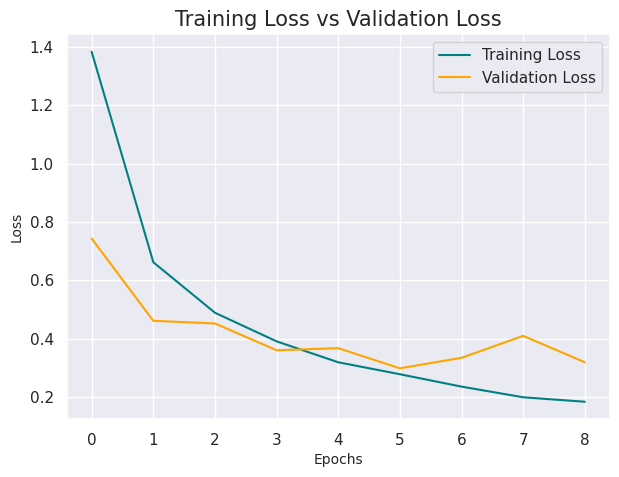

In [64]:
plt.figure(figsize = (7, 5))
plt.plot(history2.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history2.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training Loss vs Validation Loss', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

In [65]:
y_pred2 = model2.predict(X_test)

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [66]:
y_p2 = [np.argmax(i) for i in y_pred2]

In [67]:
print(classification_report(y_test, y_p2))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90       100
           1       0.99      0.90      0.94       148
           2       0.95      0.96      0.96       100
           3       0.76      0.99      0.86       100
           4       0.71      0.80      0.75        15
           5       0.96      0.99      0.97       213
           6       0.83      0.69      0.75       100
           7       0.85      0.83      0.84       191
           8       0.94      0.87      0.91        95
           9       0.89      0.84      0.87       177
          10       0.94      0.88      0.91       168
          11       0.79      0.93      0.86       140
          12       1.00      0.98      0.99       321
          13       1.00      1.00      1.00        37
          14       0.92      1.00      0.96       159

    accuracy                           0.91      2064
   macro avg       0.90      0.90      0.90      2064
weighted avg       0.92   

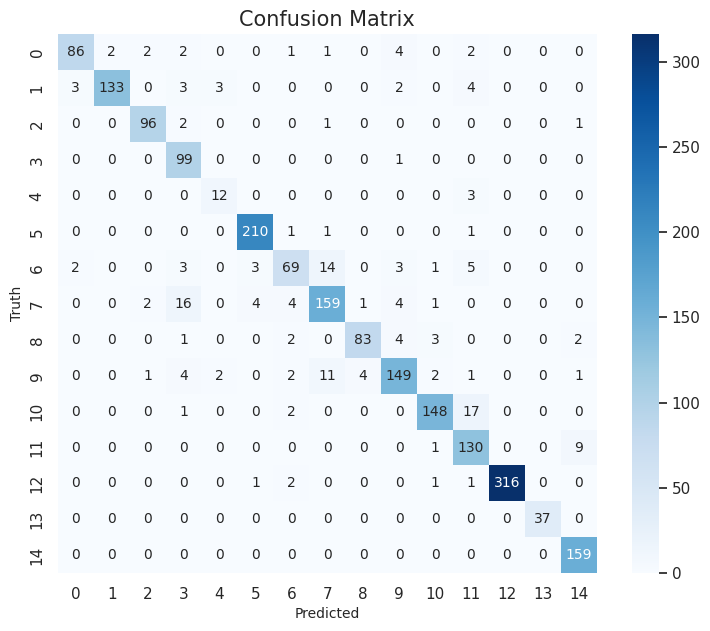

In [68]:
plt.figure(figsize = (9, 7))
sns.heatmap(confusion_matrix(y_test, y_p2), annot = True, square = True, cbar = True, annot_kws = {'size': 10}, fmt = 'd',
           cmap = 'Blues')
plt.title('Confusion Matrix', fontsize = 15)
plt.xlabel('Predicted', fontsize = 10)
plt.ylabel('Truth', fontsize = 10)
plt.show()

In [70]:
base_model = DenseNet121(weights = 'imagenet', include_top = False, input_shape = (80, 80, 3))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [76]:
model3 = Sequential()

In [77]:
model3.add(base_model)
model3.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size = (2, 2)))
model3.add(Flatten())
model3.add(Dense(128, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.001)))
model3.add(Dropout(0.5))
model3.add(Dense(15, activation = 'softmax'))

In [79]:
model3.compile(
    optimizer = Adam(learning_rate = 1e-4),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [80]:
history3 = model3.fit(X_train, y_train, epochs = 100, validation_data = (X_val, y_val), callbacks = [early_stopping2])

Epoch 1/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 239s 227ms/step - accuracy: 0.4266 - loss: 1.9716 - val_accuracy: 0.9246 - val_loss: 0.3494
Epoch 2/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 35s 67ms/step - accuracy: 0.8928 - loss: 0.5058 - val_accuracy: 0.9652 - val_loss: 0.1959
Epoch 3/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.9588 - loss: 0.2619 - val_accuracy: 0.9749 - val_loss: 0.1480
Epoch 4/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.9777 - loss: 0.1705 - val_accuracy: 0.9754 - val_loss: 0.1469
Epoch 5/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.9804 - loss: 0.1401 - val_accuracy: 0.9807 - val_loss: 0.1233
Epoch 6/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.9843 - loss: 0.1212 - val_accuracy: 0.9720 - val_loss: 0.1791
Epoch 7/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.9866 - loss: 0.1119 - val_accuracy: 0.9618 - val_loss: 0.1950
Epoch 8/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.9846 - loss:

In [81]:
model3.evaluate(X_test, y_test)

65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.9782 - loss: 0.1056


[0.14161066710948944, 0.9665697813034058]

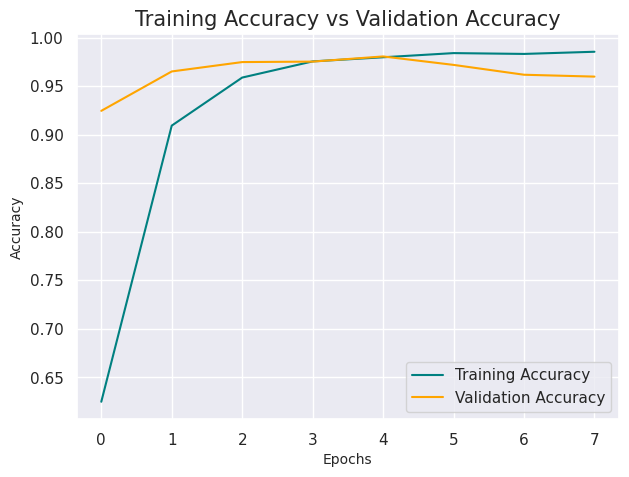

In [82]:
plt.figure(figsize = (7, 5))
plt.plot(history3.history['accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history3.history['val_accuracy'], label = 'Validation Accuracy', color = 'orange')
plt.title('Training Accuracy vs Validation Accuracy', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.legend()
plt.show()

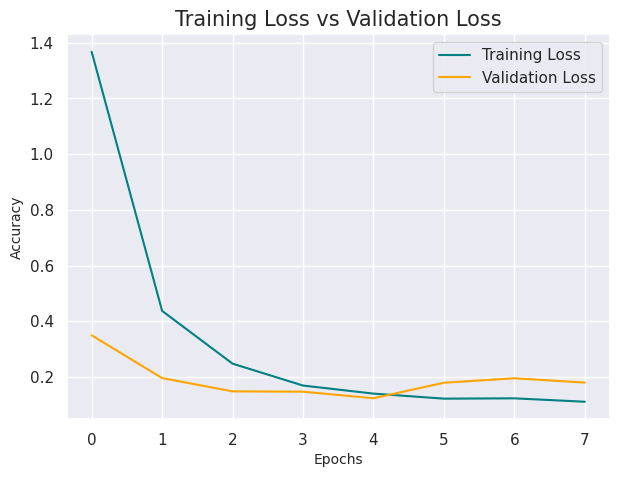

In [83]:
plt.figure(figsize = (7, 5))
plt.plot(history3.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history3.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training Loss vs Validation Loss', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.legend()
plt.show()

In [84]:
y_pred3 = model3.predict(X_test)

65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step


In [85]:
y_p3 = [np.argmax(i) for i in y_pred3]

In [87]:
print(classification_report(y_test, y_p3))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       100
           1       1.00      0.97      0.98       148
           2       0.96      0.99      0.98       100
           3       0.99      0.96      0.97       100
           4       0.94      1.00      0.97        15
           5       1.00      1.00      1.00       213
           6       0.94      0.88      0.91       100
           7       0.99      0.91      0.95       191
           8       0.99      0.94      0.96        95
           9       0.86      0.99      0.92       177
          10       1.00      0.91      0.95       168
          11       0.87      0.98      0.92       140
          12       1.00      0.99      0.99       321
          13       0.97      1.00      0.99        37
          14       1.00      1.00      1.00       159

    accuracy                           0.97      2064
   macro avg       0.97      0.97      0.97      2064
weighted avg       0.97   

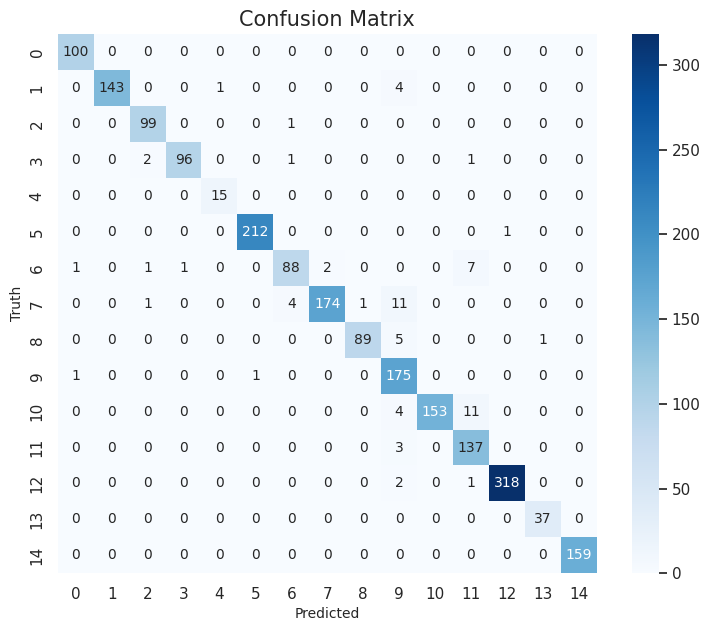

In [88]:
plt.figure(figsize = (9, 7))
sns.heatmap(confusion_matrix(y_test, y_p3), annot = True, square = True, cbar = True, annot_kws = {'size': 10}, fmt = 'd',
           cmap = 'Blues')
plt.title('Confusion Matrix', fontsize = 15)
plt.xlabel('Predicted', fontsize = 10)
plt.ylabel('Truth', fontsize = 10)
plt.show()

In [91]:
base_model2 = ResNet50(weights = 'imagenet', include_top = False, input_shape = (80, 80, 3))

In [100]:
model4 = Sequential()

In [101]:
model4.add(base_model2)
model4.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size = (2, 2)))
model4.add(Flatten())
model4.add(Dense(128, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.001)))
model4.add(Dropout(0.5))
model4.add(Dense(15, activation = 'softmax'))

In [102]:
model4.compile(
    optimizer = Adam(learning_rate = 1e-4),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [103]:
early_stopping4 = EarlyStopping(monitor = 'val_loss', patience = 3)

In [104]:
history4 = model4.fit(X_train, y_train, epochs = 100, validation_data = (X_val, y_val), callbacks = [early_stopping4])

Epoch 1/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 103s 109ms/step - accuracy: 0.8689 - loss: 0.5861 - val_accuracy: 0.9676 - val_loss: 0.1990
Epoch 2/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 38s 73ms/step - accuracy: 0.9833 - loss: 0.1638 - val_accuracy: 0.9812 - val_loss: 0.1355
Epoch 3/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 37s 72ms/step - accuracy: 0.9873 - loss: 0.1203 - val_accuracy: 0.9850 - val_loss: 0.1132
Epoch 4/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 37s 72ms/step - accuracy: 0.9888 - loss: 0.1131 - val_accuracy: 0.9797 - val_loss: 0.1261
Epoch 5/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 37s 72ms/step - accuracy: 0.9864 - loss: 0.1145 - val_accuracy: 0.9667 - val_loss: 0.1841
Epoch 6/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 37s 72ms/step - accuracy: 0.9872 - loss: 0.1099 - val_accuracy: 0.9812 - val_loss: 0.1185


In [105]:
model4.evaluate(X_test, y_test)

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9855 - loss: 0.1082


[0.10874481499195099, 0.9859496355056763]

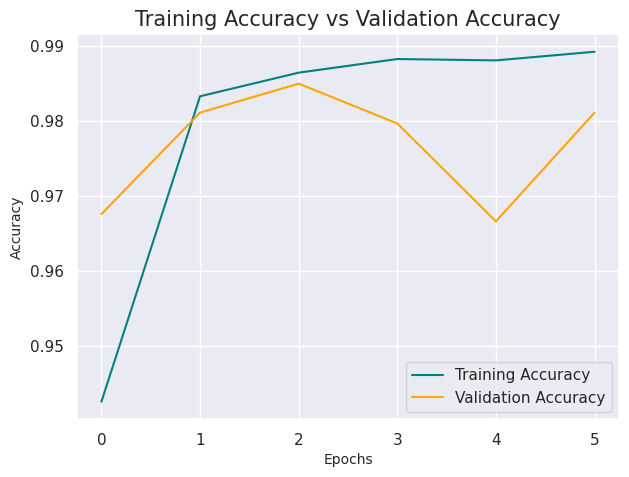

In [106]:
plt.figure(figsize = (7, 5))
plt.plot(history4.history['accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history4.history['val_accuracy'], label = 'Validation Accuracy', color = 'orange')
plt.title('Training Accuracy vs Validation Accuracy', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.legend()
plt.show()

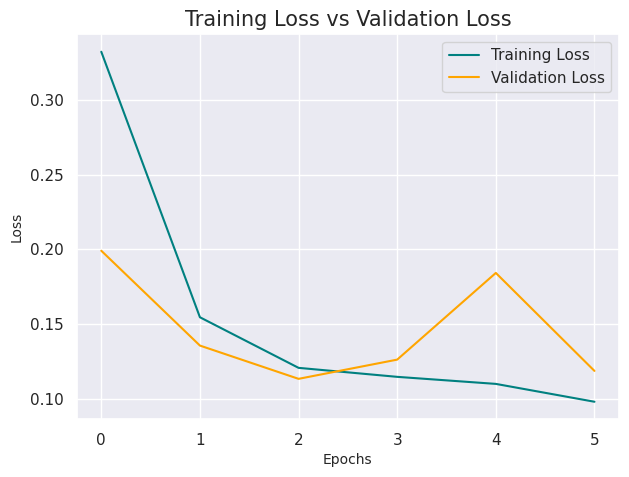

In [108]:
plt.figure(figsize = (7, 5))
plt.plot(history4.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history4.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training Loss vs Validation Loss', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

In [109]:
y_pred4 = model4.predict(X_test)

65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step


In [110]:
y_p4 = [np.argmax(i) for i in y_pred4]

In [111]:
print(classification_report(y_test, y_p4))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       148
           2       1.00      1.00      1.00       100
           3       0.95      1.00      0.98       100
           4       1.00      1.00      1.00        15
           5       0.99      0.99      0.99       213
           6       0.98      0.95      0.96       100
           7       0.96      0.98      0.97       191
           8       1.00      0.93      0.96        95
           9       0.98      0.97      0.98       177
          10       0.97      0.99      0.98       168
          11       0.97      0.96      0.97       140
          12       1.00      1.00      1.00       321
          13       1.00      1.00      1.00        37
          14       1.00      1.00      1.00       159

    accuracy                           0.99      2064
   macro avg       0.99      0.99      0.99      2064
weighted avg       0.99   

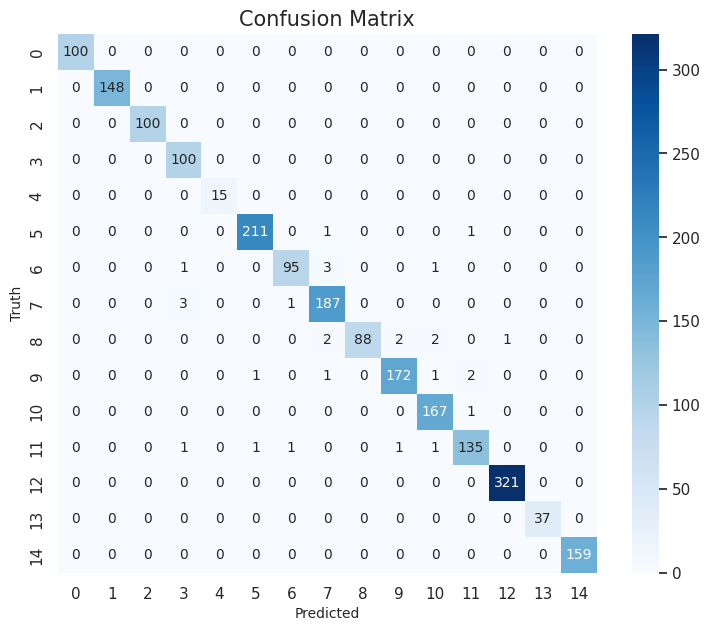

In [112]:
plt.figure(figsize = (9, 7))
sns.heatmap(confusion_matrix(y_test, y_p4), annot = True, square = True, cbar = True, annot_kws = {'size': 10}, fmt = 'd',
           cmap = 'Blues')
plt.title('Confusion Matrix', fontsize = 15)
plt.xlabel('Predicted', fontsize = 10)
plt.ylabel('Truth', fontsize = 10)
plt.show()